# 01 - Clustering Notebook
The intent of this notebook is to cluster our data to find meaningful relationships within the data. Within this notebook, we will be scaling the data we would like to cluster, then perform a FeatureUnion to bring in the remaining data, before running it through both a DBScan and KMeans model. At the end of the notebook, we analyze our findings by cluster.

In [1]:
## Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('ggplot') 
# %matplotlib inline

# sklearn imports
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
np.random.seed(40)

In [3]:
df_2018 = pd.read_csv('./source_data/economies_2018.csv', index_col =0)
df_2021 = pd.read_csv('./source_data/economies_2021.csv', index_col =0)

df_2018.head()

,Total Nonfarm,Manufacturing,"Trade, Transportation, and Utils",Information,Financial Activities,Professional & Business Services,Education & Health Services,Leisure & Hospitality,Other Services,Government,...,pct_Manufacturing,"pct_Trade, Transportation, and Utils",pct_Information,pct_Financial Activities,pct_Professional & Business Services,pct_Education & Health Services,pct_Leisure & Hospitality,pct_Other Services,pct_Government,"pct_Mining, Logging and Construction"
Alabama,2046.258,266.992,383.467,21.092,96.258,244.242,245.167,205.933,97.117,386.792,...,0.1305,0.1874,0.0103,0.0470,0.1194,0.1198,0.1006,0.0475,0.1890,0.0485
Alaska,327.658,12.500,64.408,5.608,11.767,27.358,50.442,35.650,11.058,80.375,...,0.0381,0.1966,0.0171,0.0359,0.0835,0.1539,0.1088,0.0337,0.2453,0.0870
Arizona,2857.717,171.450,534.525,47.558,220.008,434.033,445.417,325.975,92.442,415.858,...,0.0600,0.1870,0.0166,0.0770,0.1519,0.1559,0.1141,0.0323,0.1455,0.0596
Arkansas,1267.492,160.800,253.408,12.433,61.058,145.425,191.575,118.267,55.650,212.108,...,0.1269,0.1999,0.0098,0.0482,0.1147,0.1511,0.0933,0.0439,0.1673,0.0448
California,17172.225,1323.550,3045.983,542.850,837.875,2670.217,2722.283,1993.142,571.667,2581.483,...,0.0771,0.1774,0.0316,0.0488,0.1555,0.1585,0.1161,0.0333,0.1503,0.0514


In [4]:
# Check for null values in dataframes
print(df_2021.isnull().sum())
print(df_2018.isnull().sum())

Total Nonfarm                           0
Manufacturing                           0
Trade, Transportation, and Utils        0
Information                             0
Financial Activities                    0
Professional & Business Services        0
Education & Health Services             0
Leisure & Hospitality                   0
Other Services                          0
Government                              0
Mining, Logging and Construction        0
pct_Manufacturing                       0
pct_Trade, Transportation, and Utils    0
pct_Information                         0
pct_Financial Activities                0
pct_Professional & Business Services    0
pct_Education & Health Services         0
pct_Leisure & Hospitality               0
pct_Other Services                      0
pct_Government                          0
pct_Mining, Logging and Construction    0
dtype: int64
Total Nonfarm                           0
Manufacturing                           0
Trade, Transportation

#### Scaling & FeatureUnion within Pipelines

In [5]:
target_columns = df_2018.drop(columns=df_2018.columns[1:11]).columns
target_columns

Index(['Total Nonfarm', 'pct_Manufacturing',
       'pct_Trade, Transportation, and Utils', 'pct_Information',
       'pct_Financial Activities', 'pct_Professional & Business Services',
       'pct_Education & Health Services', 'pct_Leisure & Hospitality',
       'pct_Other Services', 'pct_Government',
       'pct_Mining, Logging and Construction'],
      dtype='object')

#### The following functions are used within the Pipelines for either the scaled data or FeatureUnion

In [6]:
def get_scaled_columns(df):
    return pd.DataFrame(df[target_columns[0]])

get_scaled_transformer = FunctionTransformer(get_scaled_columns, validate=False)

In [7]:
def get_non_scaled_columns(df):
    return df[target_columns[1:]]

get_non_scaled_transformer = FunctionTransformer(get_non_scaled_columns, validate=False)

In [8]:
pipe_scaler = Pipeline([
    ('scale_transform', get_scaled_transformer),
    ('ss', StandardScaler())
])

In [9]:
union = FeatureUnion([
    ('vect_pipe', pipe_scaler),
    ('other_cols', get_non_scaled_transformer)
])

union_res = union.fit_transform(df_2018)

In [10]:
df_2018_sc = pd.DataFrame(union_res, columns=target_columns)
df_2018_sc.head()

,Total Nonfarm,pct_Manufacturing,"pct_Trade, Transportation, and Utils",pct_Information,pct_Financial Activities,pct_Professional & Business Services,pct_Education & Health Services,pct_Leisure & Hospitality,pct_Other Services,pct_Government,"pct_Mining, Logging and Construction"
0,-0.273332,0.1305,0.1874,0.0103,0.0470,0.1194,0.1198,0.1006,0.0475,0.1890,0.0485
1,-0.810216,0.0381,0.1966,0.0171,0.0359,0.0835,0.1539,0.1088,0.0337,0.2453,0.0870
2,-0.019835,0.0600,0.1870,0.0166,0.0770,0.1519,0.1559,0.1141,0.0323,0.1455,0.0596
3,-0.516615,0.1269,0.1999,0.0098,0.0482,0.1147,0.1511,0.0933,0.0439,0.1673,0.0448
4,4.451965,0.0771,0.1774,0.0316,0.0488,0.1555,0.1585,0.1161,0.0333,0.1503,0.0514


#### DBScan Clustering
Using DBScan to determine how best to cluster the data.

In [11]:
from sklearn.cluster import DBSCAN
def find_best_silhouette(X):     
    max_score=-1
    for eps in np.linspace(0.2, 5, 20):
        for minsamples in range(2, round(len(X) / 2)):
            dbscan = DBSCAN(eps=eps, min_samples=minsamples)
            dbscan.fit(X)
            if len(set(dbscan.labels_)) > 2:
                score = silhouette_score(X, dbscan.labels_)
                if -1 in set(dbscan.labels_):
                    nclusters = len(set(dbscan.labels_)) - 1
                else:
                    nclusters = len(set(dbscan.labels_)) 
                if score > max_score:
                    max_score = score
                    best_eps = eps
                    best_minsamples = minsamples
                    best_clusters = nclusters
    print(f'Best silhouette score was {round(max_score, 5)}')
    print(f'Best eps was {round(best_eps, 2)}')
    print(f'Best min_samples was {best_minsamples}.')
    print(f'Model found {best_clusters} clusters.')
    return
find_best_silhouette(df_2018_sc)

Best silhouette score was 0.67505
Best eps was 0.45
Best min_samples was 2.
Model found 2 clusters.


#### KMeans Clustering

##### Looping through KMeans clusters to determine best Silhoutte Score

In [12]:
silhouette_list = []

for k in range(2, 25):
    kmeans = KMeans(n_clusters=k, random_state=13)
    kmeans.fit(df_2018_sc)
    silhouette_list.append(silhouette_score(df_2018_sc, kmeans.labels_))
silhouette_list

[0.7725317579175214,
 0.5963666675122845,
 0.5926641035779244,
 0.5261620829452,
 0.5120651335367421,
 0.5151200064843636,
 0.553118277856621,
 0.48382067140594986,
 0.4560331539327963,
 0.45318475173191164,
 0.4270012681119023,
 0.42812218957548565,
 0.357374064726818,
 0.3365927314742852,
 0.3020729677933735,
 0.2967180903206686,
 0.30771469355008557,
 0.29013064124215454,
 0.29598375716184433,
 0.28097741442459867,
 0.24502676837586215,
 0.2633169515505015,
 0.24556009471646326]

#### Looping through KMeans clusters to determine best Inertia Score

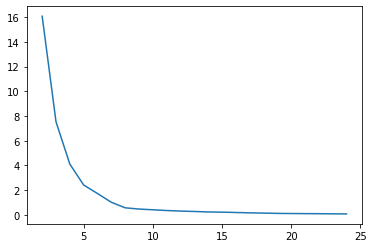

In [13]:
inertias = []
ks = list(range(2,25))

for k in ks:
    km = KMeans(n_clusters=k, random_state=13)
    km.fit(df_2018_sc)
    inertias.append(km.inertia_)
plt.plot(ks, inertias);

#### Simplified version of Scaling & FeatureUnion for 2021

In [14]:
union_res_2021 = union.fit_transform(df_2021)

In [15]:
df_2021_sc = pd.DataFrame(union_res_2021, columns=target_columns)
df_2021_sc.head()

,Total Nonfarm,pct_Manufacturing,"pct_Trade, Transportation, and Utils",pct_Information,pct_Financial Activities,pct_Professional & Business Services,pct_Education & Health Services,pct_Leisure & Hospitality,pct_Other Services,pct_Government,"pct_Mining, Logging and Construction"
0,-0.262526,0.1292,0.1934,0.0098,0.0481,0.1228,0.1172,0.0924,0.0466,0.1901,0.0505
1,-0.813071,0.0403,0.1966,0.0154,0.0347,0.0852,0.1627,0.0978,0.0337,0.2486,0.0850
2,0.029844,0.0611,0.1974,0.0160,0.0830,0.1504,0.1570,0.1028,0.0308,0.1374,0.0641
3,-0.503555,0.1225,0.1999,0.0091,0.0514,0.1139,0.1521,0.0903,0.0522,0.1614,0.0472
4,4.406927,0.0762,0.1816,0.0339,0.0493,0.1618,0.1681,0.0976,0.0299,0.1477,0.0538


##### Looping through KMeans clusters to determine best Silhoutte Score

In [16]:
silhouette_list = []

for k in range(2, 25):
    kmeans = KMeans(n_clusters=k, random_state=13)
    kmeans.fit(df_2021_sc)
    silhouette_list.append(silhouette_score(df_2021_sc, kmeans.labels_))
silhouette_list

[0.7755987844721923,
 0.6008119056628506,
 0.604852483130968,
 0.5455708943288491,
 0.5336321079938592,
 0.537554441838545,
 0.5615621790548438,
 0.479636222215527,
 0.44039647703889173,
 0.44688226260481606,
 0.35312787178551724,
 0.3514656887349095,
 0.3419796350092676,
 0.3369562471452749,
 0.3344399411653107,
 0.30649916539184335,
 0.3151808702140301,
 0.3000719457702771,
 0.30131219479653965,
 0.2707627125021187,
 0.2803145012355155,
 0.2688480550785032,
 0.28122144691771217]

##### Looping through KMeans clusters to determine best Inertia Score

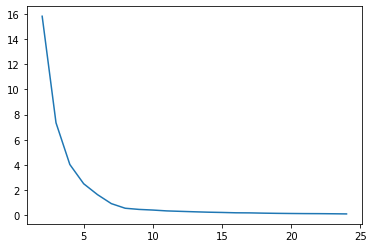

In [17]:
inertias = []
ks = list(range(2,25))

for k in ks:
    km = KMeans(n_clusters=k, random_state=13)
    km.fit(df_2021_sc)
    inertias.append(km.inertia_)
plt.plot(ks, inertias);

#### Instantiate & Fit KMeans Models

In [18]:
df_2018_clusters = df_2018.copy()
df_2021_clusters = df_2021.copy()

In [19]:
km = KMeans(n_clusters=4, random_state=13)
km.fit(df_2018_sc)
df_2018_clusters['clusters-4'] = km.labels_
km.fit(df_2021_sc)
df_2021_clusters['clusters-4'] = km.labels_
df_2018_clusters.head()

,Total Nonfarm,Manufacturing,"Trade, Transportation, and Utils",Information,Financial Activities,Professional & Business Services,Education & Health Services,Leisure & Hospitality,Other Services,Government,...,"pct_Trade, Transportation, and Utils",pct_Information,pct_Financial Activities,pct_Professional & Business Services,pct_Education & Health Services,pct_Leisure & Hospitality,pct_Other Services,pct_Government,"pct_Mining, Logging and Construction",clusters-4
Alabama,2046.258,266.992,383.467,21.092,96.258,244.242,245.167,205.933,97.117,386.792,...,0.1874,0.0103,0.0470,0.1194,0.1198,0.1006,0.0475,0.1890,0.0485,0
Alaska,327.658,12.500,64.408,5.608,11.767,27.358,50.442,35.650,11.058,80.375,...,0.1966,0.0171,0.0359,0.0835,0.1539,0.1088,0.0337,0.2453,0.0870,0
Arizona,2857.717,171.450,534.525,47.558,220.008,434.033,445.417,325.975,92.442,415.858,...,0.1870,0.0166,0.0770,0.1519,0.1559,0.1141,0.0323,0.1455,0.0596,2
Arkansas,1267.492,160.800,253.408,12.433,61.058,145.425,191.575,118.267,55.650,212.108,...,0.1999,0.0098,0.0482,0.1147,0.1511,0.0933,0.0439,0.1673,0.0448,0
California,17172.225,1323.550,3045.983,542.850,837.875,2670.217,2722.283,1993.142,571.667,2581.483,...,0.1774,0.0316,0.0488,0.1555,0.1585,0.1161,0.0333,0.1503,0.0514,3


##### Viewing outputs by cluster

In [20]:
# 4 clusters sil score = 0.545
for r in range(4):
    print(f'cluster {r}')
    print(df_2018_clusters[df_2018_clusters['clusters-4']==r].index)
    print()

cluster 0
Index(['Alabama', 'Alaska', 'Arkansas', 'Connecticut', 'Delaware',
       'District of Columbia', 'Hawaii', 'Idaho', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Mississippi', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Mexico', 'North Dakota', 'Oklahoma', 'Oregon',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Utah', 'Vermont',
       'West Virginia', 'Wyoming'],
      dtype='object')

cluster 1
Index(['Florida', 'New York', 'Texas'], dtype='object')

cluster 2
Index(['Arizona', 'Colorado', 'Georgia', 'Illinois', 'Indiana', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Missouri', 'New Jersey',
       'North Carolina', 'Ohio', 'Pennsylvania', 'Tennessee', 'Virginia',
       'Washington', 'Wisconsin'],
      dtype='object')

cluster 3
Index(['California'], dtype='object')



In [21]:
# 3 clusters sil score = 0.55
km = KMeans(n_clusters=3, random_state=13)
km.fit(df_2018_sc)
df_2018_clusters['clusters-3'] = km.labels_
for r in range(3):
    print(f'cluster {r}')
    print(df_2018_clusters[df_2018_clusters['clusters-3']==r].index)
    print()

cluster 0
Index(['Arizona', 'Colorado', 'Georgia', 'Illinois', 'Indiana', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Missouri', 'New Jersey',
       'North Carolina', 'Ohio', 'Pennsylvania', 'Tennessee', 'Virginia',
       'Washington', 'Wisconsin'],
      dtype='object')

cluster 1
Index(['California', 'Florida', 'New York', 'Texas'], dtype='object')

cluster 2
Index(['Alabama', 'Alaska', 'Arkansas', 'Connecticut', 'Delaware',
       'District of Columbia', 'Hawaii', 'Idaho', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Mississippi', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Mexico', 'North Dakota', 'Oklahoma', 'Oregon',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Utah', 'Vermont',
       'West Virginia', 'Wyoming'],
      dtype='object')



In [22]:
# 5 clusters sil score = 0.449
km = KMeans(n_clusters=5, random_state=13)
km.fit(df_2018_sc)
df_2018_clusters['clusters-5'] = km.labels_
for r in range(5):
    print(f'cluster {r}')
    print(df_2018_clusters[df_2018_clusters['clusters-5']==r].index)
    print()

cluster 0
Index(['Alabama', 'Arizona', 'Colorado', 'Indiana', 'Kentucky', 'Louisiana',
       'Maryland', 'Massachusetts', 'Minnesota', 'Missouri', 'Oregon',
       'South Carolina', 'Tennessee', 'Washington', 'Wisconsin'],
      dtype='object')

cluster 1
Index(['Florida', 'New York', 'Texas'], dtype='object')

cluster 2
Index(['Georgia', 'Illinois', 'Michigan', 'New Jersey', 'North Carolina',
       'Ohio', 'Pennsylvania', 'Virginia'],
      dtype='object')

cluster 3
Index(['Alaska', 'Arkansas', 'Connecticut', 'Delaware', 'District of Columbia',
       'Hawaii', 'Idaho', 'Iowa', 'Kansas', 'Maine', 'Mississippi', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Mexico', 'North Dakota',
       'Oklahoma', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont',
       'West Virginia', 'Wyoming'],
      dtype='object')

cluster 4
Index(['California'], dtype='object')



In [23]:
# Save dataframe to CSV in the source_data directory
df_2018_clusters.to_csv('./source_data/2018_with_clusters.csv', index_label='State')

##### Visualize statistics by cluster in a table format

In [24]:
# Used to easily visualize output of following cell
pd.set_option('display.max_rows', None)

##### To change which cluster to analyze, change the `by='clusters-5'` to `clusters-4` or `clusters-3`

In [25]:
df_2018_clusters.groupby(by='clusters-5').describe().T

clusters-5                                            0             1  \
Total Nonfarm                        count    15.000000      3.000000   
                                     mean   2698.308867  10330.241667   
                                     std     557.807815   1952.665543   
                                     min    1922.950000   8780.950000   
                                     25%    2100.541500   9233.575000   
                                     50%    2857.717000   9686.200000   
                                     75%    3023.800000  11104.887500   
                                     max    3648.558000  12523.575000   
Manufacturing                        count    15.000000      3.000000   
                                     mean    268.388333    566.314000   
                                     std     120.429876    275.669210   
                                     min     110.075000    372.908000   
                                     25%     183.283500    408.487500   
                                     50%     251.658000    444.067000   
                                     75%     304.820500    663.017000   
                                     max     542.300000    881.967000   
Trade, Transportation, and Utils     count    15.000000      3.000000   
                                     mean    497.341600   1941.267000   
                                     std      94.821875    476.373764   
                                     min     352.667000   1566.542000   
                                     25%     403.954000   1673.217000   
                                     50%     533.767000   1779.892000   
                                     75%     562.516500   2128.629500   
                                     max     636.008000   2477.367000   
Information                          count    15.000000      3.000000   
                                     mean     48.877733    209.441667   
                                     std      30.754163     72.336813   
                                     min      21.092000    139.492000   
                                     25%      29.233000    172.187500   
                                     50%      45.050000    204.883000   
                                     75%      48.354000    244.416500   
                                     max     134.200000    283.950000   
Financial Activities                 count    15.000000      3.000000   
                                     mean    148.886133    692.675000   
                                     std      44.069175    104.961752   
                                     min      93.183000    575.800000   
                                     25%     103.154000    649.562500   
                                     50%     152.975000    723.325000   
                                     75%     171.862500    751.112500   
                                     max     224.067000    778.900000   
Professional & Business Services     count    15.000000      3.000000   
                                     mean    359.616067   1478.316667   
                                     std     104.176948    232.548072   
                                     min     213.133000   1327.083000   
                                     25%     271.646000   1344.429000   
                                     50%     382.075000   1361.775000   
                                     75%     423.866500   1553.933500   
                                     max     588.408000   1746.092000   
Education & Health Services          count    15.000000      3.000000   
                                     mean    422.789533   1692.563667   
                                     std     142.254054    384.348395   
                                     min     245.167000   1305.058000   
                                     25%     310.408500   1502.008000   
                                     50%     445.417000   

#### Economic Breakdown by Cluster

In [26]:
cluster_industries = df_2018_clusters.groupby(by='clusters-5').agg('mean').T.iloc[11:-2,::]
cluster_industries.rename(index={'pct_Manufacturing':'Manufacturing',
                                 'pct_Trade, Transportation, and Utils':'Trade, Transportation, Utils',
                                 'pct_Information':'Information',
                                 'pct_Financial Activities':'Financial Activites',
                                 'pct_Professional & Business Services':'Professional & Business Services',
                                 'pct_Education & Health Services':'Education & Health Services',
                                 'pct_Leisure & Hospitality':'Leisure & Hospitality',
                                 'pct_Other Services':'Other Services',
                                 'pct_Government':'Government',
                                 'pct_Mining, Logging and Construction':'Mining, Logging, & Construction'}, inplace = True)

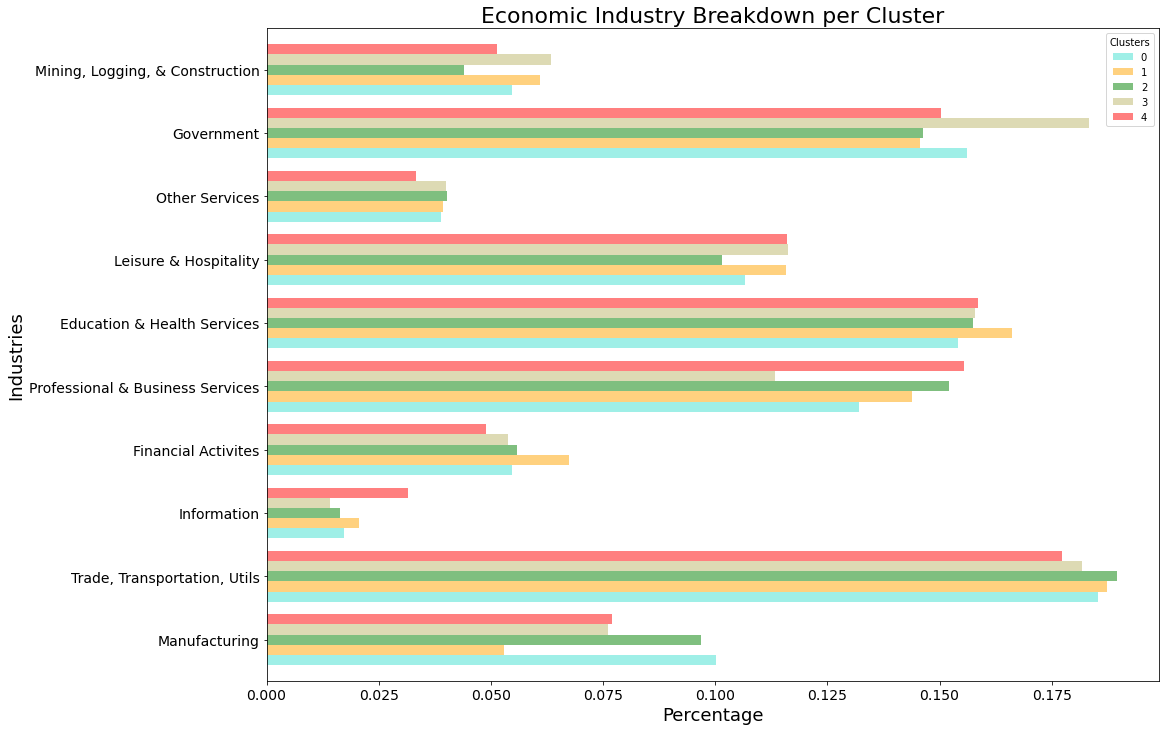

In [27]:
cluster_industries.plot.barh(figsize = (16,12), width = 0.8, color=['turquoise', 'orange',  'green', 'darkkhaki', 'red'], alpha=0.5);
plt.yticks(fontsize = '14');
plt.xticks(fontsize = '14');
plt.rcParams['axes.spines.left'] = False
# plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.spines.bottom'] = False
# plt.spines['right'].set_visible(False)
# plt.spines['bottom'].set_visible(False)
# plt.spines['left'].set_visible(False)
plt.title('Economic Industry Breakdown per Cluster', fontsize = '22')
plt.xlabel('Percentage', fontsize = '18')
plt.ylabel('Industries', fontsize = '18');
plt.legend(title = 'Clusters');

In [34]:
df_2018_clusters

,Total Nonfarm,Manufacturing,"Trade, Transportation, and Utils",Information,Financial Activities,Professional & Business Services,Education & Health Services,Leisure & Hospitality,Other Services,Government,...,pct_Professional & Business Services,pct_Education & Health Services,pct_Leisure & Hospitality,pct_Other Services,pct_Government,"pct_Mining, Logging and Construction",clusters-4,clusters-3,clusters-5,color
Alabama,2046.258,266.992,383.467,21.092,96.258,244.242,245.167,205.933,97.117,386.792,...,0.1194,0.1198,0.1006,0.0475,0.1890,0.0485,0,2,0,red
Alaska,327.658,12.500,64.408,5.608,11.767,27.358,50.442,35.650,11.058,80.375,...,0.0835,0.1539,0.1088,0.0337,0.2453,0.0870,0,2,3,yellow
Arizona,2857.717,171.450,534.525,47.558,220.008,434.033,445.417,325.975,92.442,415.858,...,0.1519,0.1559,0.1141,0.0323,0.1455,0.0596,2,0,0,red
Arkansas,1267.492,160.800,253.408,12.433,61.058,145.425,191.575,118.267,55.650,212.108,...,0.1147,0.1511,0.0933,0.0439,0.1673,0.0448,0,2,3,yellow
California,17172.225,1323.550,3045.983,542.850,837.875,2670.217,2722.283,1993.142,571.667,2581.483,...,0.1555,0.1585,0.1161,0.0333,0.1503,0.0514,3,1,4,orange
Colorado,2726.925,147.508,470.375,75.617,171.617,423.550,340.800,339.450,110.958,445.400,...,0.1553,0.1250,0.1245,0.0407,0.1633,0.0739,2,0,0,red
Connecticut,1699.275,160.667,296.500,31.667,125.467,221.092,344.792,157.783,65.617,236.358,...,0.1301,0.2029,0.0929,0.0386,0.1391,0.0349,0,2,3,yellow
Delaware,461.508,27.050,80.700,4.067,47.817,63.425,79.700,51.767,18.508,66.183,...,0.1374,0.1727,0.1122,0.0401,0.1434,0.0483,0,2,3,yellow
District of Columbia,792.958,1.342,33.208,19.158,29.592,168.117,130.892,79.808,76.783,238.400,...,0.2120,0.1651,0.1006,0.0968,0.3006,0.0197,0,2,3,yellow
Florida,8780.950,372.908,1779.892,139.492,575.800,1361.775,1305.058,1229.408,353.075,1115.008,...,0.1551,0.1486,0.1400,0.0402,0.1270,0.0624,1,1,1,green


In [36]:
kmeans.cluster_centers_

array([[-7.58108979e-01,  5.66750000e-02,  1.98525000e-01,
         1.25000000e-02,  5.60750000e-02,  9.20750000e-02,
         1.58925000e-01,  1.22050000e-01,  3.79750000e-02,
         1.90925000e-01,  7.43250000e-02],
       [ 1.94772193e+00,  4.43000000e-02,  1.81950000e-01,
         2.33000000e-02,  7.37500000e-02,  1.52300000e-01,
         1.88500000e-01,  1.02800000e-01,  3.88000000e-02,
         1.40600000e-01,  5.36000000e-02],
       [ 3.55641436e-01,  5.99000000e-02,  1.90800000e-01,
         1.71500000e-02,  5.79500000e-02,  1.83600000e-01,
         1.54000000e-01,  8.64000000e-02,  4.22000000e-02,
         1.61300000e-01,  4.66500000e-02],
       [ 4.40692703e+00,  7.62000000e-02,  1.81600000e-01,
         3.39000000e-02,  4.93000000e-02,  1.61800000e-01,
         1.68100000e-01,  9.76000000e-02,  2.99000000e-02,
         1.47700000e-01,  5.38000000e-02],
       [-3.13237624e-01,  9.89000000e-02,  2.01766667e-01,
         1.36666667e-02,  5.11333333e-02,  1.20733333e-01,
  

In [38]:
centroids = ss.inverse_transform(km.cluster_centers_)

NameError: name 'ss' is not defined

NameError: name 'centroids' is not defined

<Figure size 720x576 with 0 Axes>

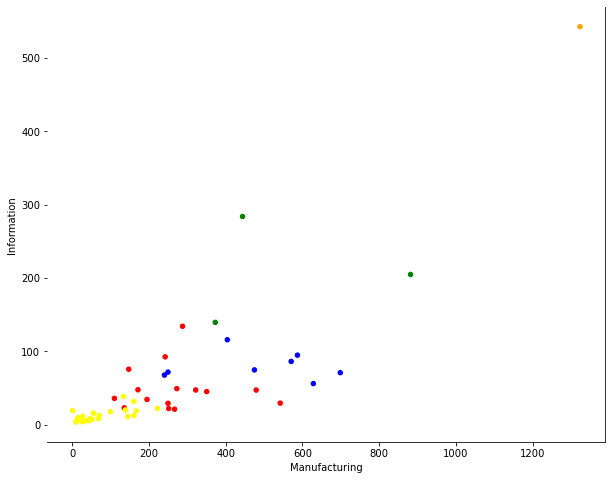

In [35]:
# Create Scatterplot!

# Figsize
plt.figure(figsize=(10,8))

# Map colors for different clusters
colors = ["red", "green", "blue", "yellow", "orange"]
df_2018_clusters['color'] = df_2018_clusters['clusters-5'].map(lambda p: colors[p])

# Plot points
ax = df_2018_clusters.plot(    
    kind="scatter", 
    x="Manufacturing", y="Information",
    figsize=(10,8),
    c = df_2018_clusters['color']
)

# Plot Centroids
centroids.plot(
    kind="scatter", 
    x="Manufacturing", y="Information", 
    marker="*", c=["r", "g", "b", "y", "o"], s=550, ax=ax
);